# DNN(FFNN)

In [99]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [100]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel,self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(25,64,bias=True),
            nn.ReLU(),
            nn.Linear(64,32,bias=True),
            nn.ReLU(),
            nn.Linear(32,32,bias=True),
            nn.ReLU(),
            nn.Linear(32,32,bias=True),
            nn.ReLU(),
            nn.Linear(32,1,bias=True)
        )
    def forward(self,x):
        out = self.seq(x)
        return out

In [101]:
model = DNNModel()

In [102]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3,verbose=True)

In [103]:
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [104]:
EPOCHS = 100
patience = 20
train_val_ratio = 0.2
batch_size = 1
best_loss = float('inf')
epoch_counter = 0
done = False
es = EarlyStopping(patience=patience)
tr_losses_for_plot,val_losses_for_plot = [],[]

# prepare DataLoader
x_train_scaled_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(np.float32), dtype=torch.float32)
x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_scaled_tensor, y_train_tensor,test_size=0.2)

train_loader = DataLoader(TensorDataset(x_tr,y_tr),batch_size=batch_size,
                         shuffle=True)
val_loader = DataLoader(TensorDataset(x_val,y_val),batch_size=batch_size,
                       shuffle=False)

while not done and epoch_counter<EPOCHS:
    epoch_counter += 1
    # train mode
    model.train()
    train_losses = []
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_for_plot.append(train_loss)
        
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_for_plot.append(train_loss)
    scheduler.step(val_loss)
    
    if es(model, val_loss):
        done = True
    
    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        

Epoch 1/100, Train Loss: 1965548849.7532, Validation Loss: 1077957230.2034
Epoch 2/100, Train Loss: 823064374.0883, Validation Loss: 626128206.0953
Epoch 3/100, Train Loss: 667894129.6258, Validation Loss: 535575886.1525
Epoch 4/100, Train Loss: 563560355.2816, Validation Loss: 432446887.6875
Epoch 5/100, Train Loss: 458395876.5191, Validation Loss: 342241305.4153
Epoch 6/100, Train Loss: 347927935.1405, Validation Loss: 229507832.4269
Epoch 7/100, Train Loss: 255902090.9601, Validation Loss: 177100760.6290
Epoch 8/100, Train Loss: 176568270.3233, Validation Loss: 133609923.8731
Epoch 9/100, Train Loss: 115896648.3318, Validation Loss: 69732792.0340
Epoch 10/100, Train Loss: 61395761.3179, Validation Loss: 33241286.0212
Epoch 11/100, Train Loss: 27966369.8285, Validation Loss: 16433241.7115
Epoch 12/100, Train Loss: 13383708.3238, Validation Loss: 7892062.0305
Epoch 13/100, Train Loss: 6845397.0311, Validation Loss: 4703981.3366
Epoch 14/100, Train Loss: 4024249.9688, Validation Loss: 

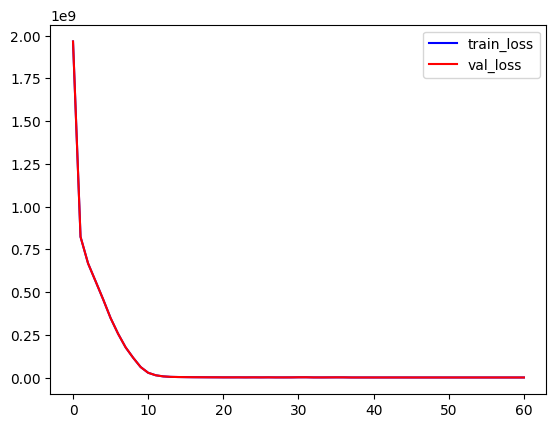

In [105]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_for_plot)),tr_losses_for_plot,color='blue',label='train_loss')
plt.plot(range(len(val_losses_for_plot)),val_losses_for_plot,color='red',label='val_loss')
plt.legend()
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error
# evaluation
model.eval()
with torch.no_grad():
    x_test_scaled_tensor = torch.tensor(x_test_scaled,dtype=torch.float32)
    pred = model(x_test_scaled_tensor)
    pred = pred.detach().numpy()
mse = mean_squared_error(y_test, pred)

In [107]:
def error_ratio(pred, true):
    return np.mean(np.abs(pred-true)/true)

print(error_ratio(pred, y_test)) # 평균적으로 1.9%의 오차율를 보인다.

0.016987154008013972


In [108]:
for i in range(5):
    print(f'종가 : {y_test[i]} / 예측가 : {pred[i]} / 오차율 : {np.abs(y_test[i]-pred[i])/y_test[i]}')

종가 : [52200] / 예측가 : [52959.344] / 오차율 : [0.014546815134099616]
종가 : [41450] / 예측가 : [40917.438] / 오차율 : [0.012848311218335344]
종가 : [49650] / 예측가 : [58524.402] / 오차율 : [0.17873922142497484]
종가 : [44800] / 예측가 : [46000.137] / 오차율 : [0.026788766043526785]
종가 : [49500] / 예측가 : [49211.105] / 오차율 : [0.005836253156565657]


In [109]:
len(np.reshape(y_test,(-1)))

127

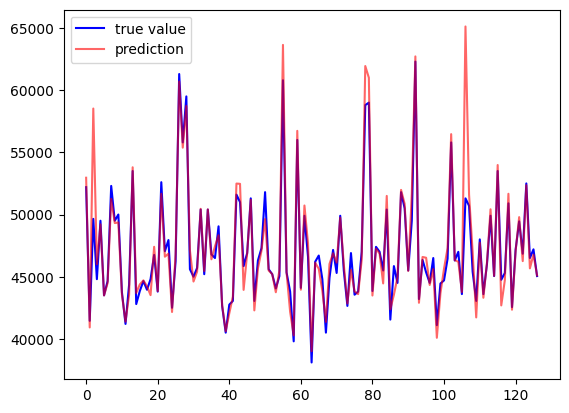

In [112]:
r = len(np.reshape(y_test,(-1)))
plt.plot(list(range(r)),np.reshape(y_test,(-1)), color='blue', label='true value')
plt.plot(list(range(r)),np.reshape(pred,(-1)), color='red',alpha=0.6, label='prediction')
plt.legend()
plt.show()